### 平安银行12-26均线策略的回测代码

##### 导入需要的库

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tushare as ts
import matplotlib

# 设置 Matplotlib 以支持中文
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 省略掉一些无关紧要的警告
import warnings
warnings.filterwarnings('ignore')

##### 设置初始变量

In [7]:
# 设置初始本金
initial_money = 1000000

# 设置短均线和长均线的时间窗口
short_window = 12
long_window = 26

# 设置比例
buy_rate = 0.20

# 设置交易成本，即滑点
cost_rate = 0.0001

# 初始化pro接口
pro = ts.pro_api('fa67857adfce740dbd6ac870e3d562e174257fffa974f4752fde3192')


##### 使用TUSHARE进行数据抓取

In [8]:
# 拉取数据
df = pro.daily(**{
    "ts_code": "000001.SZ",  # 股票代码为“平安银行”
    "trade_date": "",
    "start_date": 20221101,   # 由于回测日期从20230101开始，因此数据起始日期从20221101开始，方便获取均线数据
    "end_date": 20231231,     # 回测截止日期
    "offset": "",
    "limit": ""
}, fields=[
    "ts_code",
    "trade_date",
    "open",
    "high",
    "low",
    "close",
    "pre_close",
    "change",
    "pct_chg"
])

# 备份一个数据副本
df_copy = df

In [9]:
# 将数据全部倒叙
df = df.iloc[::-1].reset_index(drop=True)

In [10]:
#重新设置索引
df = df.set_index('trade_date') # 设置索引为日期

# 输出数据
df.head(5)

,ts_code,open,high,low,close,pre_close,change,pct_chg
trade_date,,,,,,,,
20221101,000001.SZ,10.38,10.68,10.36,10.67,10.34,0.33,3.1915
20221102,000001.SZ,10.61,10.68,10.48,10.63,10.67,-0.04,-0.3749
20221103,000001.SZ,10.54,10.57,10.38,10.44,10.63,-0.19,-1.7874
20221104,000001.SZ,10.40,10.85,10.39,10.82,10.44,0.38,3.6398
20221107,000001.SZ,10.81,10.91,10.73,10.88,10.82,0.06,0.5545


##### 交易信号框架

###### 定义均线函数

In [11]:
def Average(data, n): #data为收盘价序列，n为时间窗口   同时，data为pd.Series，因此要使用df['close']来作为输入
    return pd.Series.rolling(data, n).mean()

In [12]:
# 计算短均线
df['short_mavg'] = Average(df['close'], short_window)
# 计算长均线
df['long_mavg'] = Average(df['close'], long_window)

# 计算交易信号
df['inf'] = 0.0 # 初始化signal列为0
df['inf'] = np.where(df['short_mavg'] > df['long_mavg'], 1, 0) # 当短均线大于长均线时，signal为1，否则为0
df['trade'] = df['inf'].diff() # 当signal发生变化时，trade发生变化,代表是否进行交易


# 对数据进行截断，仅从20230101开始
df = df.loc['20230101':]
# 输出数据
df

,ts_code,open,high,low,close,pre_close,change,pct_chg,short_mavg,long_mavg,inf,trade
trade_date,,,,,,,,,,,,
20230103,000001.SZ,13.20,13.85,13.05,13.77,13.16,0.61,4.6353,13.078333,13.100769,0,0.0
20230104,000001.SZ,13.71,14.42,13.63,14.32,13.77,0.55,3.9942,13.160000,13.197308,0,0.0
20230105,000001.SZ,14.40,14.74,14.37,14.48,14.32,0.16,1.1173,13.280000,13.254615,1,1.0
20230106,000001.SZ,14.50,14.72,14.48,14.62,14.48,0.14,0.9669,13.435000,13.315769,1,0.0
20230109,000001.SZ,14.75,14.88,14.52,14.80,14.62,0.18,1.2312,13.594167,13.381154,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
20231225,000001.SZ,9.18,9.20,9.14,9.19,9.20,-0.01,-0.1087,9.200833,9.552308,0,0.0
20231226,000001.SZ,9.19,9.20,9.07,9.10,9.19,-0.09,-0.9793,9.184167,9.510385,0,0.0
20231227,000001.SZ,9.10,9.13,9.02,9.12,9.10,0.02,0.2198,9.165000,9.465769,0,0.0


In [75]:
#将df存储到excel中，手动检测数据是否正确
#df.to_excel('df.xlsx')

##### 可视化交易信号

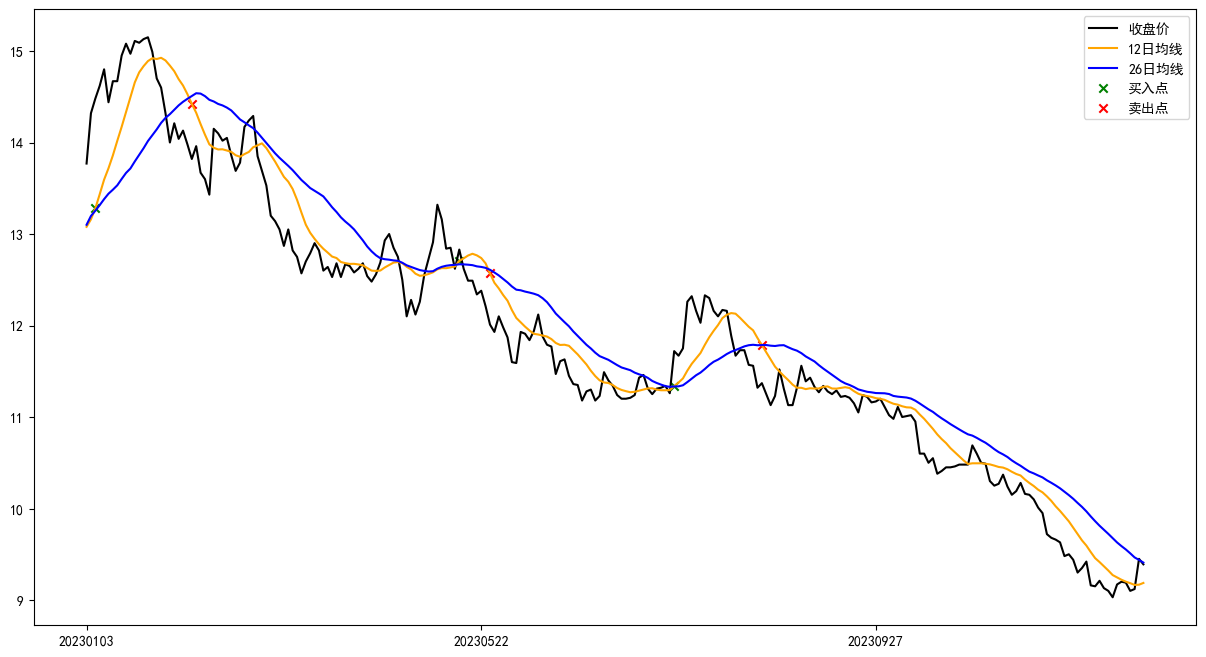

In [13]:
from matplotlib.ticker import MultipleLocator
# 创建对象
fig, ax = plt.subplots(figsize=(15, 8))

# 绘制曲线，指定不同的颜色
ax.plot(df.index, df['close'], label='收盘价', color='black')
ax.plot(df.index, df['short_mavg'], label='12日均线', color='orange')
ax.plot(df.index, df['long_mavg'], label='26日均线', color='blue')

# 仅标记 trade 列中值为 1 和 -1 的点
df_pos = df[df['trade'] == 1]
df_neg = df[df['trade'] == -1]

ax.scatter(df_pos.index, df_pos['short_mavg'], color='green', marker='x', label='买入点')
ax.scatter(df_neg.index, df_neg['short_mavg'], color='red', marker='x', label='卖出点')

# 索引间隔表示每个月
ax.xaxis.set_major_locator(MultipleLocator(90))  # 每隔2个单位显示一个刻度

# 添加图例
ax.legend()

# 显示图形
plt.show()

##### 进行策略回测

In [14]:
# 分析交易日期
# 在之前的数据处理中，已经给出了交易信号
# 由于交易信号的计算是基于短均线和长均线的交叉，因此当trade值变成1时，代表买入，-1时代表卖出
# 同时，由于trade的值为当日的信号，且使用的是收盘价数据，因此需要将实际的调仓向后移动一天，才能代表真正的交易
# 倘若在trade为1或-1时进行调仓，相当于掌握了未来信息，会导致过拟合问题

In [15]:
# 设置持仓的股票份数,初始状态全部设置为0
# 设置现金持有量
# 设置总资产价值
df['stock_num'] = 0
df['cash'] = initial_money
df['total'] = df['cash'] + df['stock_num'] * df['close']

df.head(5)

,ts_code,open,high,low,close,pre_close,change,pct_chg,short_mavg,long_mavg,inf,trade,stock_num,cash,total
trade_date,,,,,,,,,,,,,,,
20230103,000001.SZ,13.20,13.85,13.05,13.77,13.16,0.61,4.6353,13.078333,13.100769,0,0.0,0,1000000,1000000.0
20230104,000001.SZ,13.71,14.42,13.63,14.32,13.77,0.55,3.9942,13.160000,13.197308,0,0.0,0,1000000,1000000.0
20230105,000001.SZ,14.40,14.74,14.37,14.48,14.32,0.16,1.1173,13.280000,13.254615,1,1.0,0,1000000,1000000.0
20230106,000001.SZ,14.50,14.72,14.48,14.62,14.48,0.14,0.9669,13.435000,13.315769,1,0.0,0,1000000,1000000.0
20230109,000001.SZ,14.75,14.88,14.52,14.80,14.62,0.18,1.2312,13.594167,13.381154,1,0.0,0,1000000,1000000.0


###### 策略交易代码

In [16]:
# 进行交易
for i in range(1, len(df)-1):
    if i>len(df)-2: # 如果i超出了df的长度，就跳出循环,结束策略回测
        break

    else :        # 如果i还在范围内，则继续进行回测

        if df['trade'][i] == 1:

            # 买入股票的数量（向下取整）
            df['stock_num'][i+1] = int(buy_rate*df['cash'][i+1] / df['close'][i+1])

            #输出买入的股票数
            print(df.index[i+1])
            print('买入股票 {} 只\n'.format(df['stock_num'][i+1]))

            # 更新现金持有量
            # 需要减去交易费率
            df['cash'][i + 1] = df['cash'][i] - df['stock_num'][i+1] * df['close'][i] * (1 + cost_rate)

            # 更新总资产价值
            df['total'][i + 1] = df['cash'][i + 1] + df['stock_num'][i+1] * df['close'][i+1]  

        elif df['trade'][i] == -1:
            # 清仓股票
            df['stock_num'][i+1] = 0   # 卖出股票，股票数量为0
            
            #输出清仓日期
            print(df.index[i+1])
            print('清仓\n')
            
            # 更新现金持有量，需要减去交易费率
            df['cash'][i + 1] = df['close'][i + 1] * df['stock_num'][i]*(1 - cost_rate) + df['cash'][i]   # 更新现金持有量

            df['total'][i + 1] = df['cash'][i + 1] + df['stock_num'][i+1] * df['close'][i + 1]  # 更新总资产价值

        elif df['trade'][i] == 0:
            # 没有交易信号，则保持股票的持仓不变
            df['stock_num'][i + 1] = df['stock_num'][i]
            # 现金持有量不变
            df['cash'][i + 1] = df['cash'][i]
            # 总资产随着股票价值而变化
            df['total'][i + 1] = df['cash'][i+1] + df['stock_num'][i+1]*df['close'][i+1]



# 设置浮点数显示格式
pd.set_option('display.float_format', '{:.2f}'.format)

20230106
买入股票 13679 只

20230214
清仓

20230516
买入股票 15847 只

20230525
清仓

20230726
买入股票 17137 只

20230823
清仓



In [ ]:
#df.to_excel('df-回测.xlsx')

##### 绘制总资产价值的图像

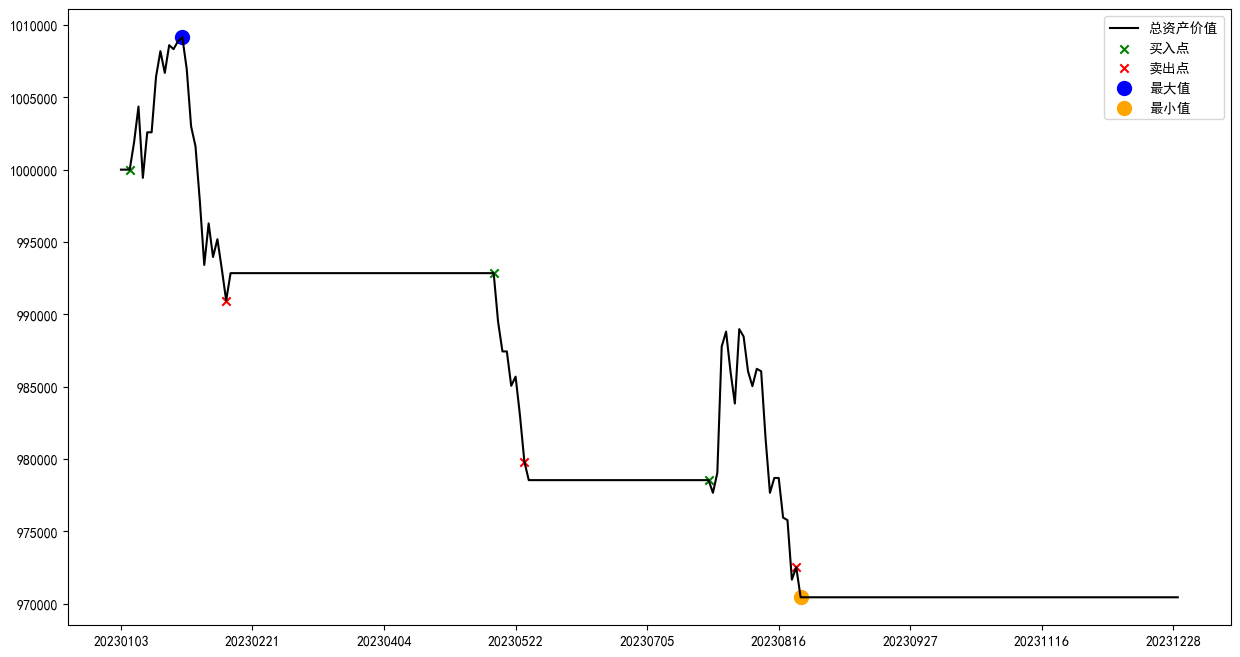

In [17]:
from matplotlib.ticker import MaxNLocator

# 创建对象
fig, ax = plt.subplots(figsize=(15, 8))

# 绘制曲线，指定不同的颜色
ax.plot(df.index, df['total'], label='总资产价值', color='black')

# 仅标记 trade 列中值为 1 和 -1 的点
df_pos = df[df['trade'] == 1]
df_neg = df[df['trade'] == -1]

ax.scatter(df_pos.index, df_pos['total'], color='green', marker='x', label='买入点')
ax.scatter(df_neg.index, df_neg['total'], color='red', marker='x', label='卖出点')

# 禁用科学计数法
ax.ticklabel_format(style='plain', axis='y')

# 标注 total 序列的最大值和最小值点
max_idx = df['total'].idxmax()
min_idx = df['total'].idxmin()
ax.scatter(max_idx, df['total'].max(), color='blue', s=100, label='最大值')
ax.scatter(min_idx, df['total'].min(), color='orange', s=100, label='最小值')

# 设置 x 轴刻度间隔
ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))

# 添加图例
ax.legend()

# 显示图形
plt.show()

##### 返回评价指标

In [18]:
# 计算每日收益率
df['daily_return'] = df['total'].pct_change()

# 计算累计收益率
df['cumulative_return'] = (1 + df['daily_return']).cumprod() - 1

# 计算最大收益率
df['cumulative_min'] = df['total'].cummin()
df['max_return'] = (df['total'] - df['cumulative_min']) / df['cumulative_min']
max_return = df['max_return'].max()


# 计算累计收益率
df['cumulative_return'] = (1 + df['daily_return']).cumprod() - 1

# 计算累计最大值
df['cumulative_max'] = df['cumulative_return'].cummax()

# 计算回撤
df['drawdown'] = df['cumulative_return'] - df['cumulative_max']

# 最大回撤
max_drawdown = df['drawdown'].min()

# 最大回撤结束日期
end_date = df['drawdown'].idxmin()

# 最大回撤开始日期
start_date = df.loc[:end_date, 'cumulative_return'].idxmax()

print(f"最大收益率: {max_return:.2%}")
print(f"实际收益率：{df['cumulative_return'].iloc[-1]:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"最大回撤开始日期: {start_date}")
print(f"最大回撤结束日期: {end_date}")

最大收益率: 1.16%
实际收益率：-2.95%
最大回撤: -3.87%
最大回撤开始日期: 20230130
最大回撤结束日期: 20230823
